### Testing cloud-cover detection with a clear-sky LWd ensemble @ CUES

Estimate the clear-sky downward longwave using several different methods. Test and compare the ensemble mean clear-sky downward longwave (LWd) to measured LWd at the CUES site to try and identify cloud-cover. We expect observed LWd to be greater than estimated clear-sky LWd when we have cloud-cover. This should be especially useful for identifying cloud-cover during nighttime when we don't have shortwave solar radiation to also check if we have sunny or cloudy skies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

Import the clear-sky downward longwave functions:

In [23]:
import lw_clr

---
# Test the LW functions:

#### Import observations from CUES site:

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

Open CUES temperature data files, and concatenate them together

In [5]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\temperature'
cues_temp_files = getListOfFiles(directory)

cues_temp_data = []
_ = [cues_temp_data.append(pd.read_csv(i)) for i in cues_temp_files]
cues_temp_data = pd.concat(cues_temp_data)

# Convert the 'DateTime' text strings to pandas datetime objects
cues_temp_data['datetime']  = pd.to_datetime(cues_temp_data['MeasDateTime'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_cues_temp_data = cues_temp_data.set_index('datetime')
_cues_temp_data.sort_index(inplace=True)
cues_ds = _cues_temp_data.to_xarray()

# drop old time field
cues_ds = cues_ds.drop_vars(names='MeasDateTime')

Open CUES radiation data file(s):

In [6]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\radiation'
cues_rad_files = getListOfFiles(directory)

cues_rad_data = []
_ = [cues_rad_data.append(pd.read_csv(i)) for i in cues_rad_files]
cues_rad_data = pd.concat(cues_rad_data)

# Convert the 'DateTime' text strings to pandas datetime objects
cues_rad_data['datetime']  = pd.to_datetime(cues_rad_data['MeasDateTime'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_cues_rad_data = cues_rad_data.set_index('datetime')
_cues_rad_data.sort_index(inplace=True)
cues_rad = _cues_rad_data.to_xarray()
cues_rad = cues_rad.drop_vars(names='MeasDateTime')

Load GOES observations for the CUES site

In [7]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


#### Run ensemble of all these LW estimation methods:

Set up input variables from CUES observations:

In [8]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
Ta = T + 273.15 # temperature [K]
Qsi = cues_rad['upward looking solar radiation; uplooking Eppley Lab precision spectral pyranometer; (Watts/meter^2)']
elev = 3000

Impor the clear sky longwave funtions

Run the ensemble function

In [10]:
lw_ensemble = lw_clr.ensemble(Ta, RH, elev)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
cues_rad = xr.merge([cues_rad, lw_ensemble])

Run the ensemble and add results of each run to a dataset:

In [12]:
#lw_ensemble = xr.Dataset()
#lw_ensemble['Lclr_angstrom1918'] = angstrom1918(To,RH)
#lw_ensemble['Lclr_brunt1932'] = brunt1932(To,RH)
#lw_ensemble['Lclr_brutsaert1975'] = brutsaert1975(To,RH)
#lw_ensemble['Lclr_garratt1992'] = garratt1992(To,RH)
#lw_ensemble['Lclr_idsojackson1969'] = idsojackson1969(To,RH)
#lw_ensemble['Lclr_idso1981'] = idso1981(To,RH)
#lw_ensemble['Lclr_iziomon2003'] = iziomon2003(To,RH,elev)
#lw_ensemble['Lclr_keding1989'] = keding1989(To,RH)
#lw_ensemble['Lclr_niemela2001'] = niemela2001(To,RH)
#lw_ensemble['Lclr_prata1996'] = prata1996(To,RH)
#lw_ensemble['Lclr_satturlund1979'] = satturlund1979(To,RH)
#lw_ensemble['Lclr_swinbank1963'] = swinbank1963(To)
#lw_ensemble['Lclr_dilleyobrien1998'] = dilleyobrien1998(To,RH)
#lw_ensemble['Lclr_maykutchurch1973'] = maykutchurch1973(To)
#lw_ensemble['Lclr_konzelmann1994'] = konzelmann1994(To,RH)
#lw_ensemble['Lclr_campbellnorman1998'] = campbellnorman1998(To)
#lw_ensemble['Lclr_ohmura1982'] = ohmura1982(To)
#lw_ensemble['Lclr_efimova1961'] = efimova1961(To,RH)

Take the mean, min, max of the ensemble:

In [13]:
#Lclr_mean = lw_ensemble.to_array(dim='new').mean('new')
#Lclr_min = lw_ensemble.to_array(dim='new').min('new')
#Lclr_max = lw_ensemble.to_array(dim='new').max('new')
#lw_ensemble = lw_ensemble.assign(Lclr_mean=Lclr_mean)
#lw_ensemble = lw_ensemble.assign(Lclr_min=Lclr_min)
#lw_ensemble = lw_ensemble.assign(Lclr_max=Lclr_max)

Add all the results to the CUES Radiation dataset:

In [14]:
#cues_rad = xr.merge([cues_rad, lw_ensemble])

---
# Plot results:

Set up font sizes for plot

In [15]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For each estimation method, plot the estimated clear-sky LWd versus observed all-sky LWd:

In [16]:
# Function for making these plots
def plot_2dhist_LWensemble(x,y_,row,col):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax[row,col].imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax[row,col].plot([0,400],[0,400],'-',c='grey')
    ax[row,col].text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax[row,col].text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax[row,col].set_xlim([100,400])
    ax[row,col].set_ylim([100,400])
    ax[row,col].set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax[row,col].set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax[row,col].set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

In [18]:
x = cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = [cues_rad.lclr_angstrom1918,cues_rad.lclr_brunt1932,cues_rad.lclr_brutsaert1975,cues_rad.lclr_garratt1992,
     cues_rad.lclr_idsojackson1969, cues_rad.lclr_idso1981,cues_rad.lclr_iziomon2003,cues_rad.lclr_keding1989,
     cues_rad.lclr_niemela2001,cues_rad.lclr_prata1996,cues_rad.lclr_satturlund1979,cues_rad.lclr_swinbank1963,
     cues_rad.lclr_dilleyobrien1998,cues_rad.lclr_maykutchurch1973,
     cues_rad.lclr_campbellnorman1998,cues_rad.lclr_ohmura1982,cues_rad.lclr_efimova1961,
     cues_rad.lclr_mean, cues_rad.lclr_min, cues_rad.lclr_max]

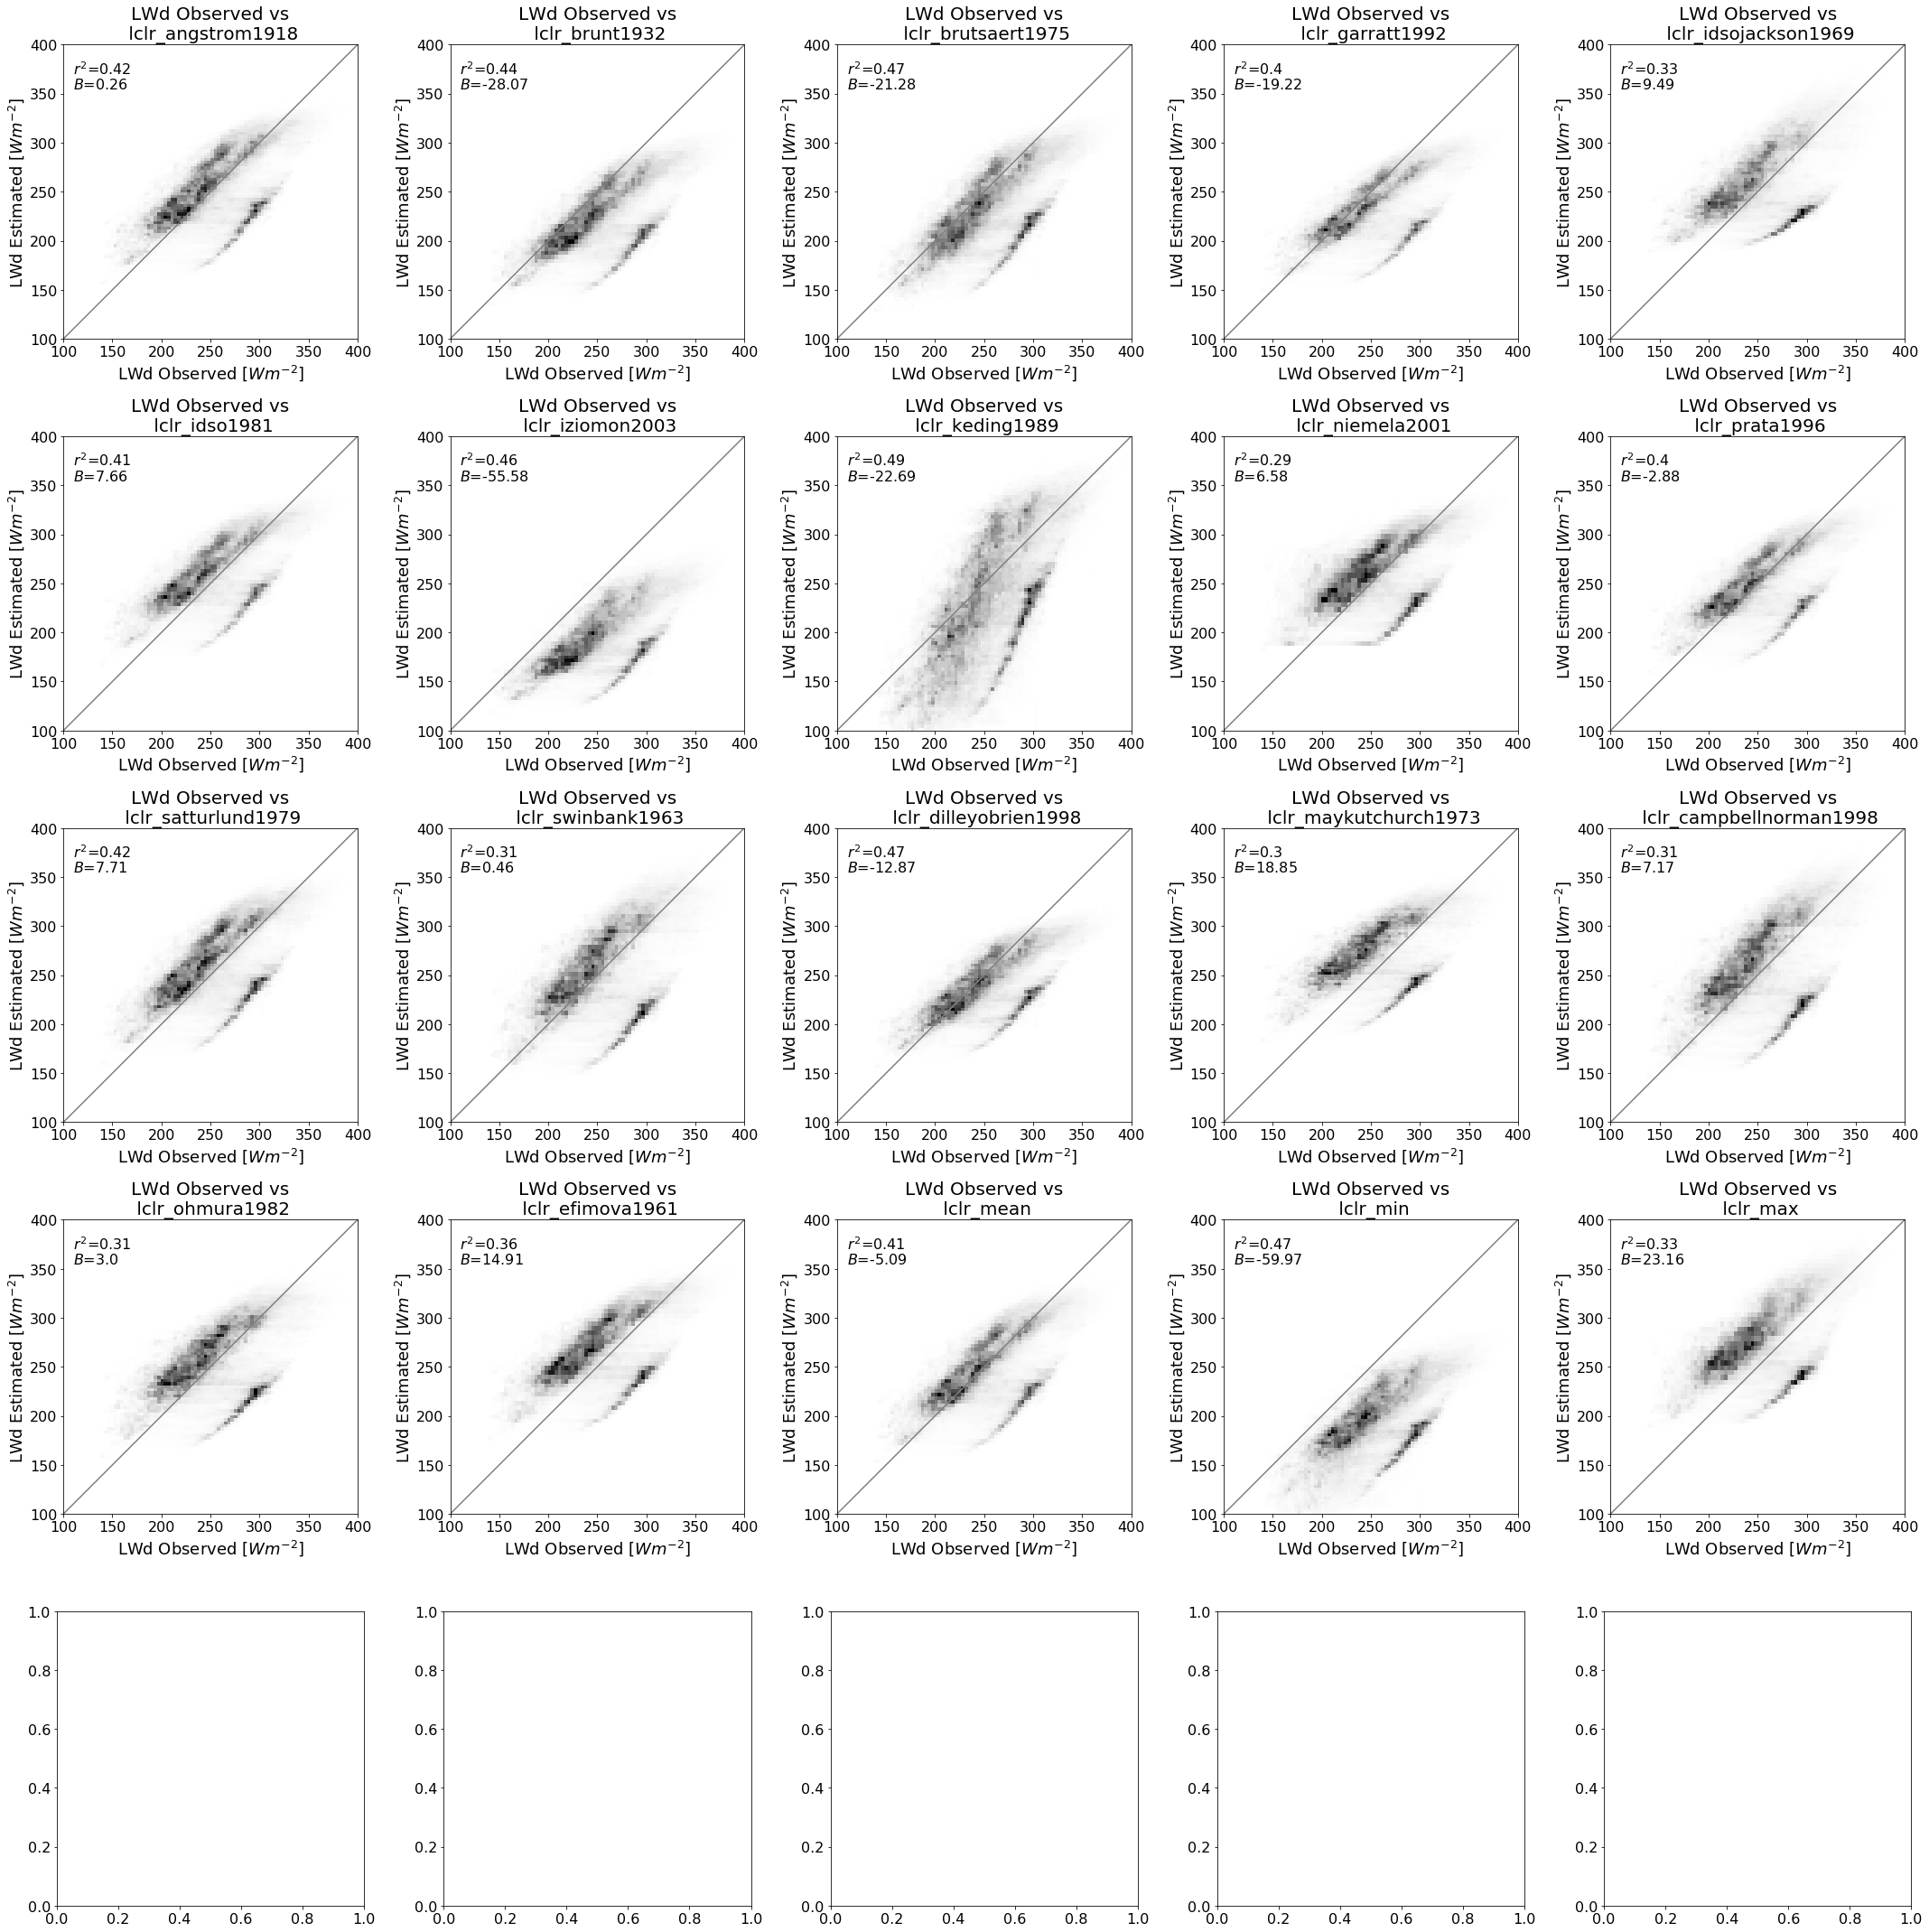

In [19]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x,y[(row*5)+col],row,col)
        except IndexError:
            pass
plt.tight_layout()

Plot only for clear-sky conditions (sun flag = 1)

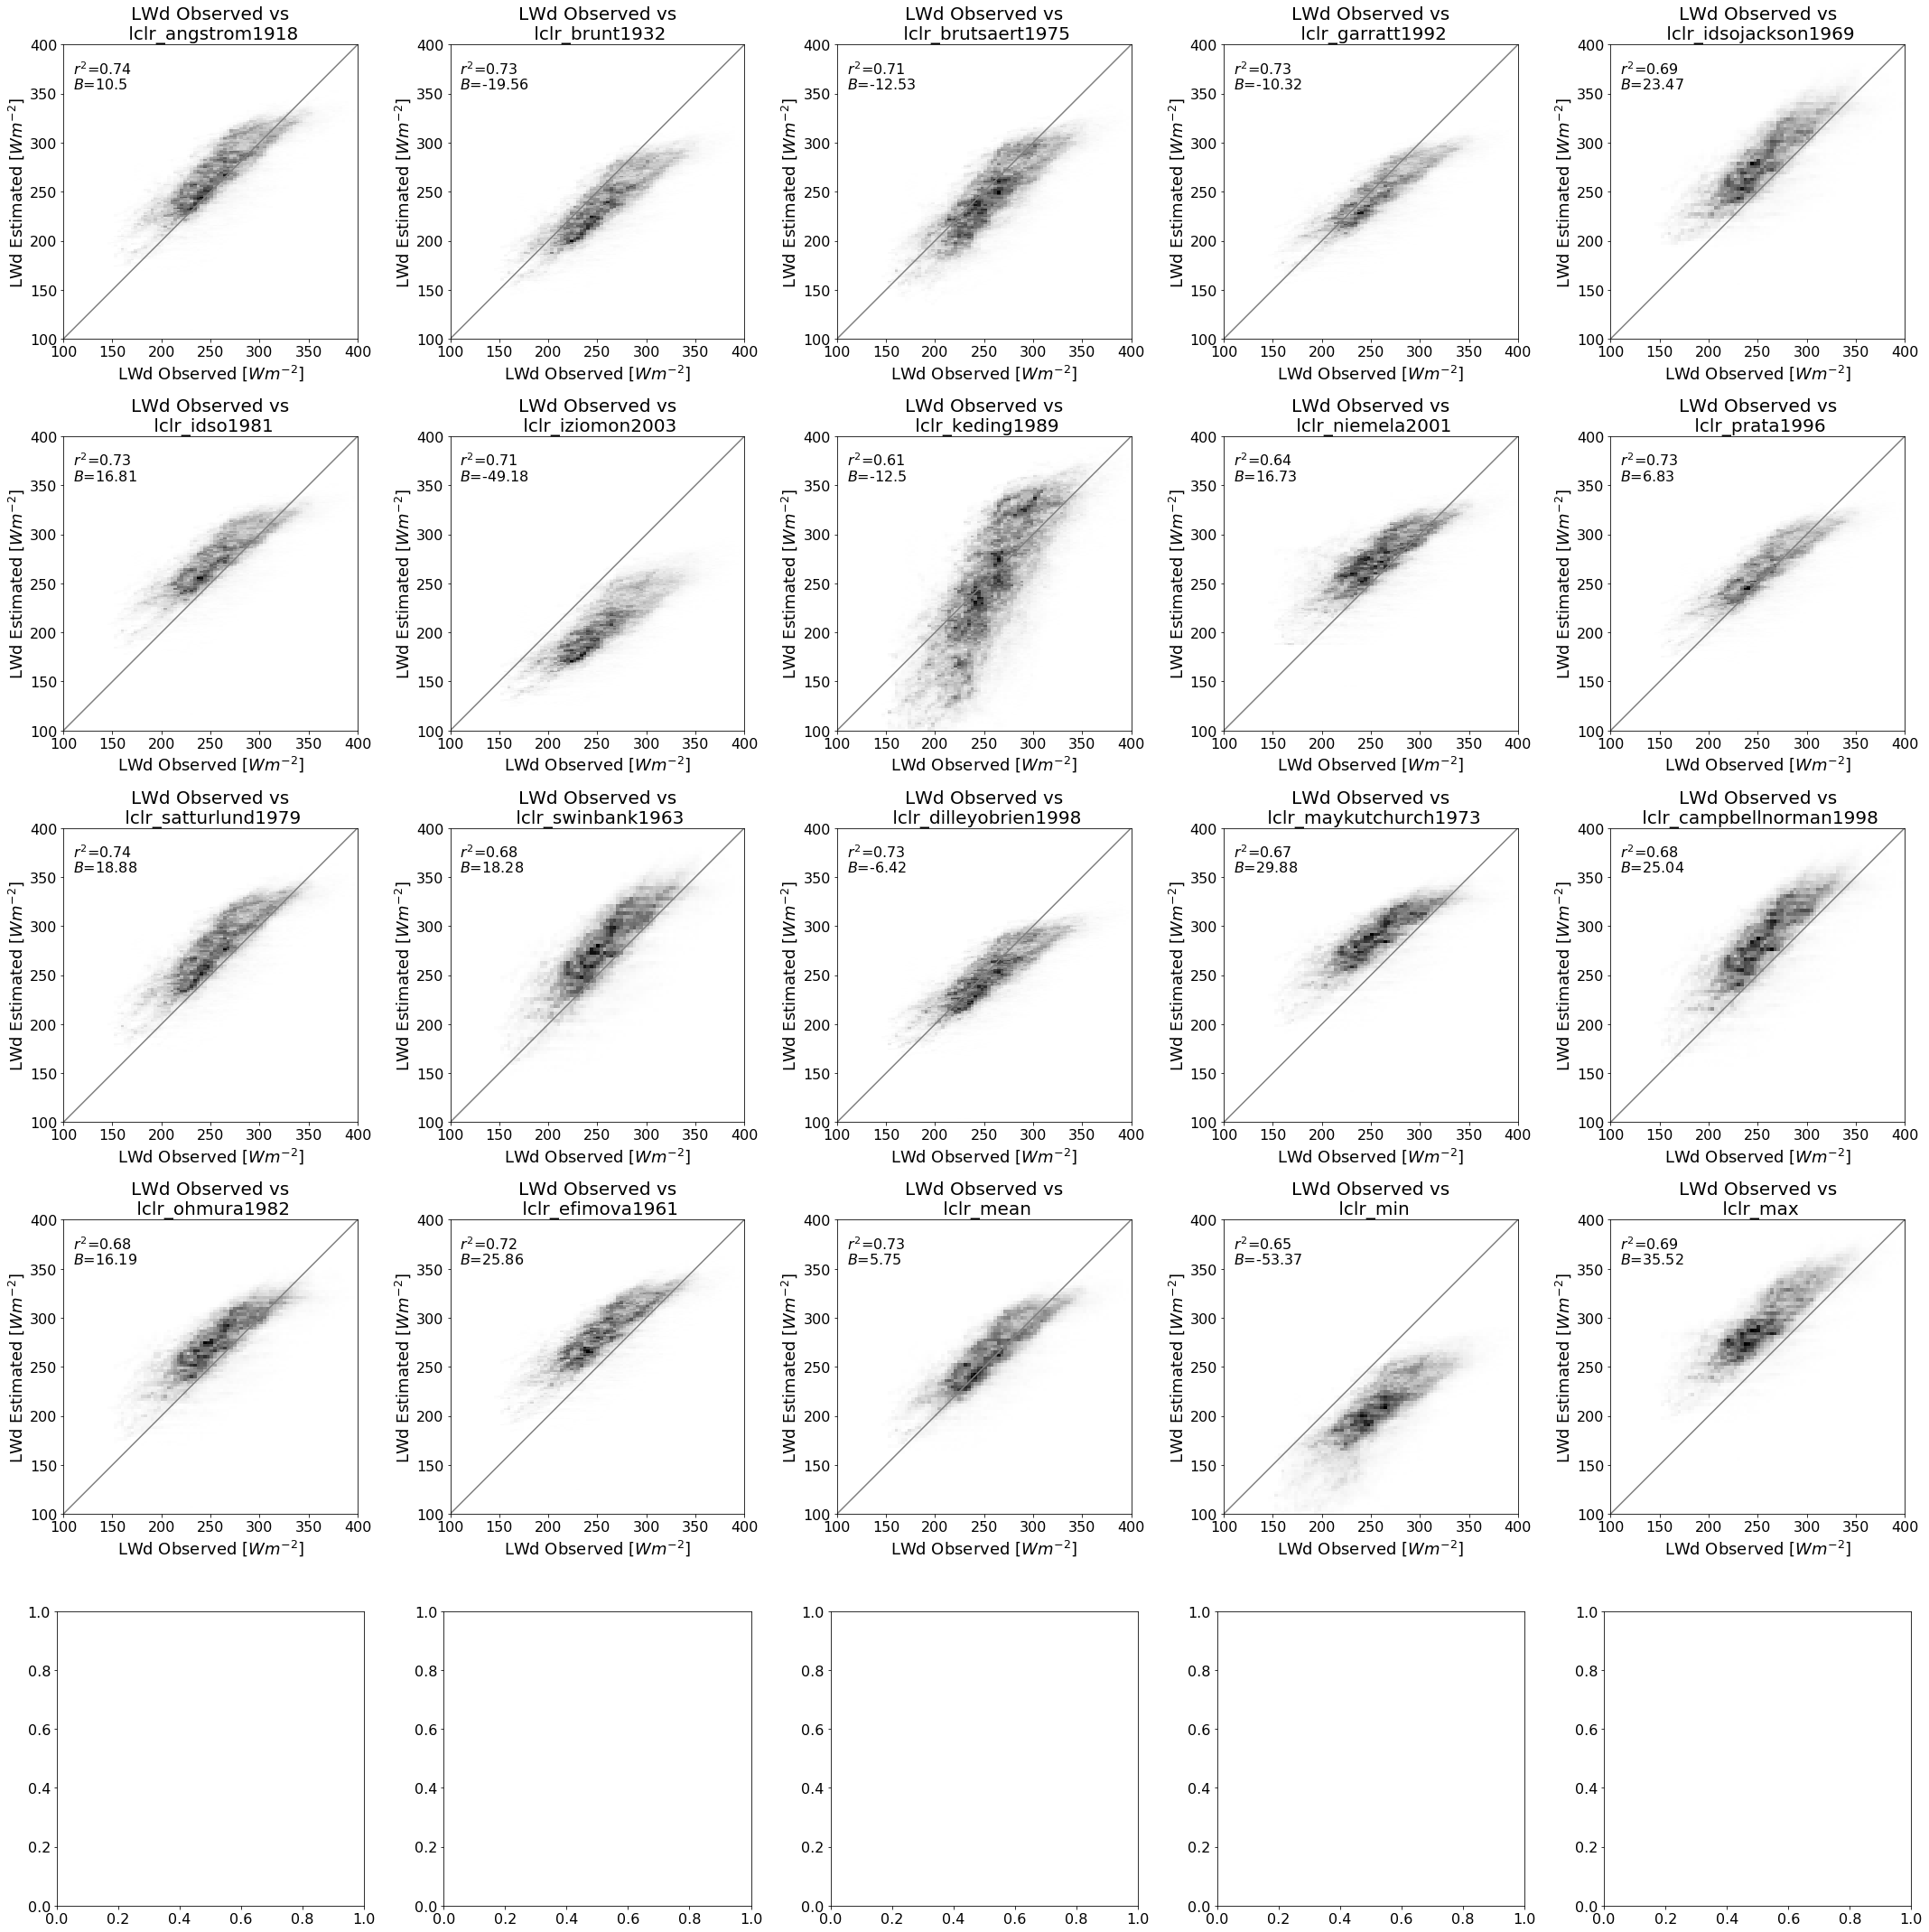

In [20]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x.where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                                   y[(row*5)+col].where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
                                   ,row,col)
        except IndexError:
            pass
plt.tight_layout()

Plot some results zoomed in to a couple days:

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


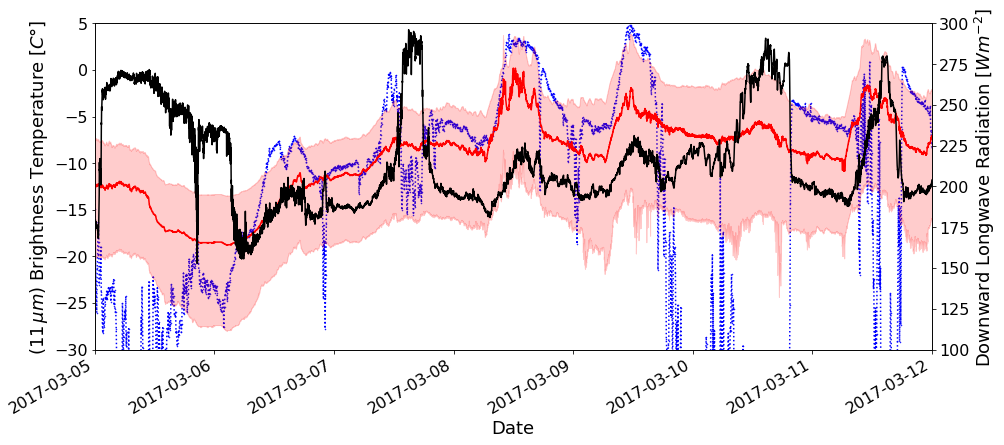

In [22]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,5)
enddate = pd.datetime(2017,3,12)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()


lw_ensemble.lclr_mean.plot(ax=ax2,alpha=1,c='r')
ax2.fill_between(lw_ensemble.datetime, lw_ensemble.lclr_max, lw_ensemble.lclr_min,color='r',alpha=0.2)


# Observed Downward Lognwave Radiation
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2, c='k')

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)

#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='b', linestyle=':', marker='.', markersize=1, ax=ax)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((100,300))
ax.set_ylim((-30,5))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]');

# make legend
#lines = [ax.lines[0], ax2.lines[0], ax2.lines[1]]
#labels = ['GOES Brightness Temp.', 'Clear-Sky Downward LW', 'CUES: Downward LW']
#ax.legend(lines, labels, loc='upper left')

---
---

# Identify periods of cloud-cover

Can we use a classification or clustering model, comparing our observed all-sky LWd to ensemble estimated clear-sky LWd, to identify periods of cloud cover? During periods of cloud cover, we expect our observed LWd to be greater than the ensemble clear-sky LWd.

Here I'm using a Gaussian Mixture Model to try and identify clusters where observed LWd and ensemble estimated LWd 1) match approximately 1-to-1, or 2) observed LWd > estimated LWd.

In [ ]:
from sklearn import mixture

In [ ]:
# Define the datasets we are using here:
# observations of all-sky LWd
x = cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']#.where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
# ensemble mean estimated clear-sky LWd
y = cues_rad.Lclr_mean#.where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
# observed "sun flag", we'll use this to check how well the GMM does
sun = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
# make a "daytime" flag where we'll just look at hours between 8 am and 4 pm, we'll use this to check how well the GMM does
hours = np.array([pd.Timestamp(x).hour for x in cues_rad.datetime.values])
daytime_flag = (hours > 8) & (hours < 16)

In [ ]:
# Structure our data for the GMM
df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1['sun'] = sun
df1['day'] = daytime_flag
df1 = df1.dropna() # dropping NaN values
x = df1.x
y = df1.y
sun = df1.sun
sun_flag = sun==1 # T/F array to use indexing later
daytime_flag = df1.day # T/F array to use indexing later
X = np.array([x.values,y.values]).T # reshape to match GMM's expected format

In [ ]:
# predict clusters with GMM
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', tol=1e-3, n_init=5 ).fit(X)
gmm_labels = gmm.predict(X)

Plot the results of the GMM, compare against our known periods of cloud-free daytime skies (sunny flag in CUES data).

In [ ]:
# Plot the results
fig, ax = plt.subplots(2,2,figsize=(10,10))

# Plot the GMM results for all data
ax[0,0].scatter(X[:, 0], 
            X[:, 1], c=gmm_labels, s=1, cmap='jet', alpha=0.05);
ax[0,0].plot([0,400],[0,400],':b')
ax[0,0].set_xlim([100,400])
ax[0,0].set_ylim([100,400])
ax[0,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,0].set_title('Gaussian Mixture Model\n(all conditions)')

# Plot the GMM results for our sunny skies data
ax[1,0].scatter(X[:, 0][sun_flag & daytime_flag], 
            X[:, 1][sun_flag & daytime_flag], c=gmm_labels[sun_flag & daytime_flag], s=1, cmap='jet', alpha=0.05);
ax[1,0].plot([0,400],[0,400],':b')
ax[1,0].set_xlim([100,400])
ax[1,0].set_ylim([100,400])
ax[1,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,0].set_title('Gaussian Mixture Model\n(Daytime & Clear Skies)')

# Plot the GMM results for when we don't have sunny skies but its still daytime (likely cloudy)
ax[0,1].scatter(X[:, 0][~sun_flag & daytime_flag], 
           X[:, 1][~sun_flag & daytime_flag], c=gmm_labels[~sun_flag & daytime_flag], s=1, cmap='jet', alpha=0.05);
ax[0,1].plot([0,400],[0,400],':b')
ax[0,1].set_xlim([100,400])
ax[0,1].set_ylim([100,400])
ax[0,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,1].set_title('Gaussian Mixture Model\n(Daytime & Cloudy)')

# Plot the GMM results for when we don't have sunny skies and its nighttime
ax[1,1].scatter(X[:, 0][~sun_flag & ~daytime_flag], 
           X[:, 1][~sun_flag & ~daytime_flag], c=gmm_labels[~sun_flag & ~daytime_flag], s=1, cmap='jet', alpha=0.05);
ax[1,1].plot([0,400],[0,400],':b')
ax[1,1].set_xlim([100,400])
ax[1,1].set_ylim([100,400])
ax[1,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,1].set_title('Gaussian Mixture Model\n(Nighttime)')

#plt.colorbar()
plt.tight_layout()